<a href="https://colab.research.google.com/github/mqquiroz/pygmt/blob/main/Test_colab_PyGMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!conda --version
!pip install -q condacolab
import condacolab
condacolab.install()

!conda create --name pygmt-env gmt
!conda activate pygmt-env
!conda install pygmt
!pip install --force-reinstall pandas

✨🍰✨ Everything looks OK!


Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local/envs/pygmt-env

  added / updated specs:
    - gmt


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu
  blosc              conda-forge/linux-64::blosc-1.21.1-h83bc5f7_3
  boost-cpp          conda-forge/linux-64::boost-cpp-1.78.0-h75c5d50_1
  bzip2              conda-forge/linux-64::bzip2-1.0.8-h7f98852_4
  c-ares             conda-forge/linux-64::c-ares-1.18.1-h7f98852_0
  ca-certificates    conda-forge/linux-64::ca-certificates-2022.9.24-ha878542_0
  cairo              conda-forge/linux-64::cairo-1.16.0-ha61ee94_1014
  cfitsio            conda-forge

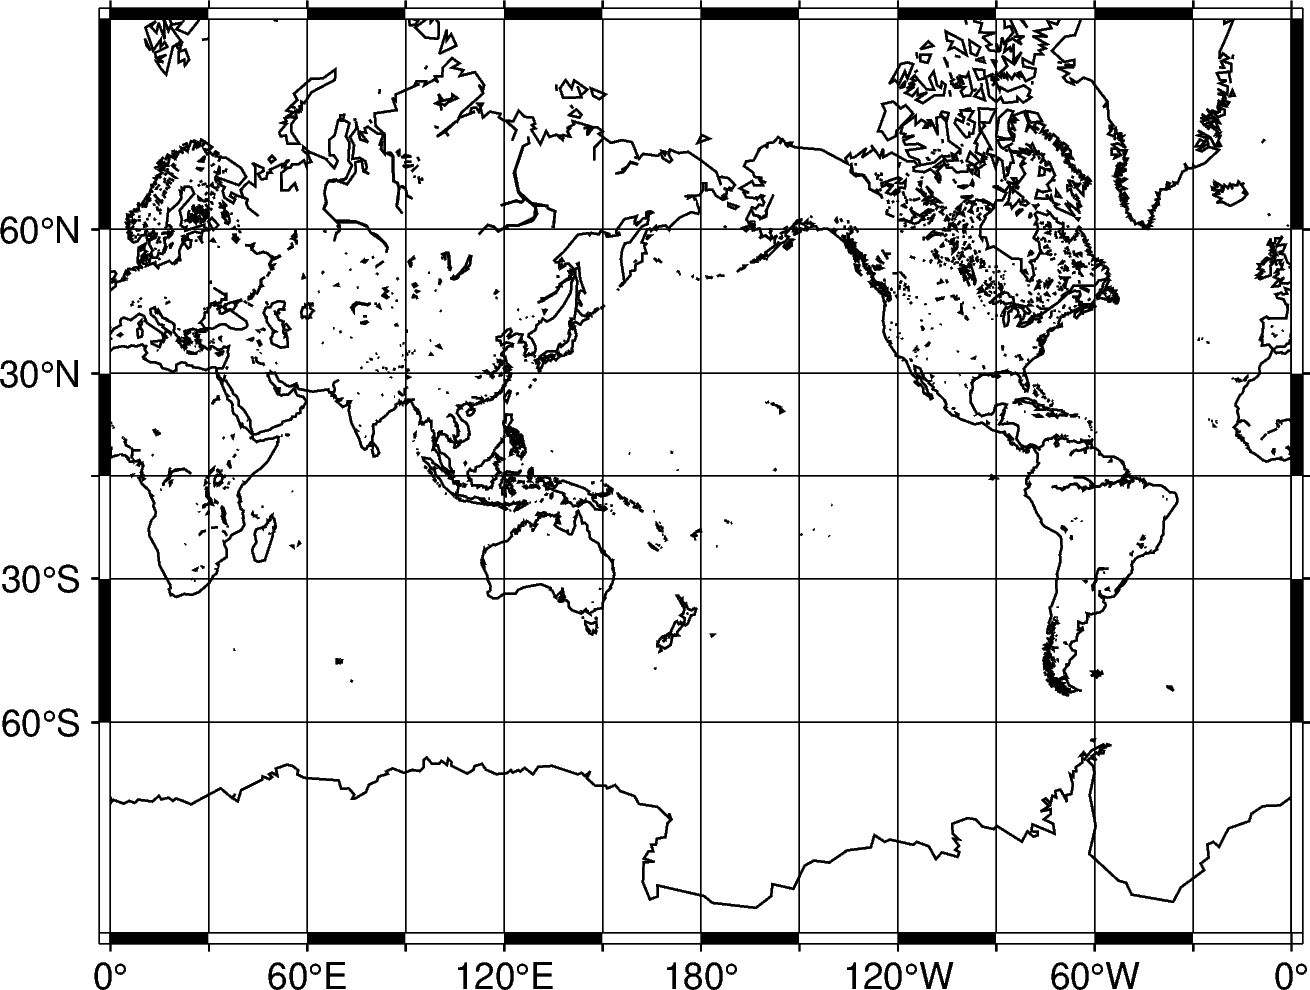

In [29]:
import pygmt
#pygmt.show_versions()

fig = pygmt.Figure()
fig.coast(region=[0, 360, -80, 80], projection="M0/0/10c", frame="a30fg", shorelines=0.5)
fig.show()

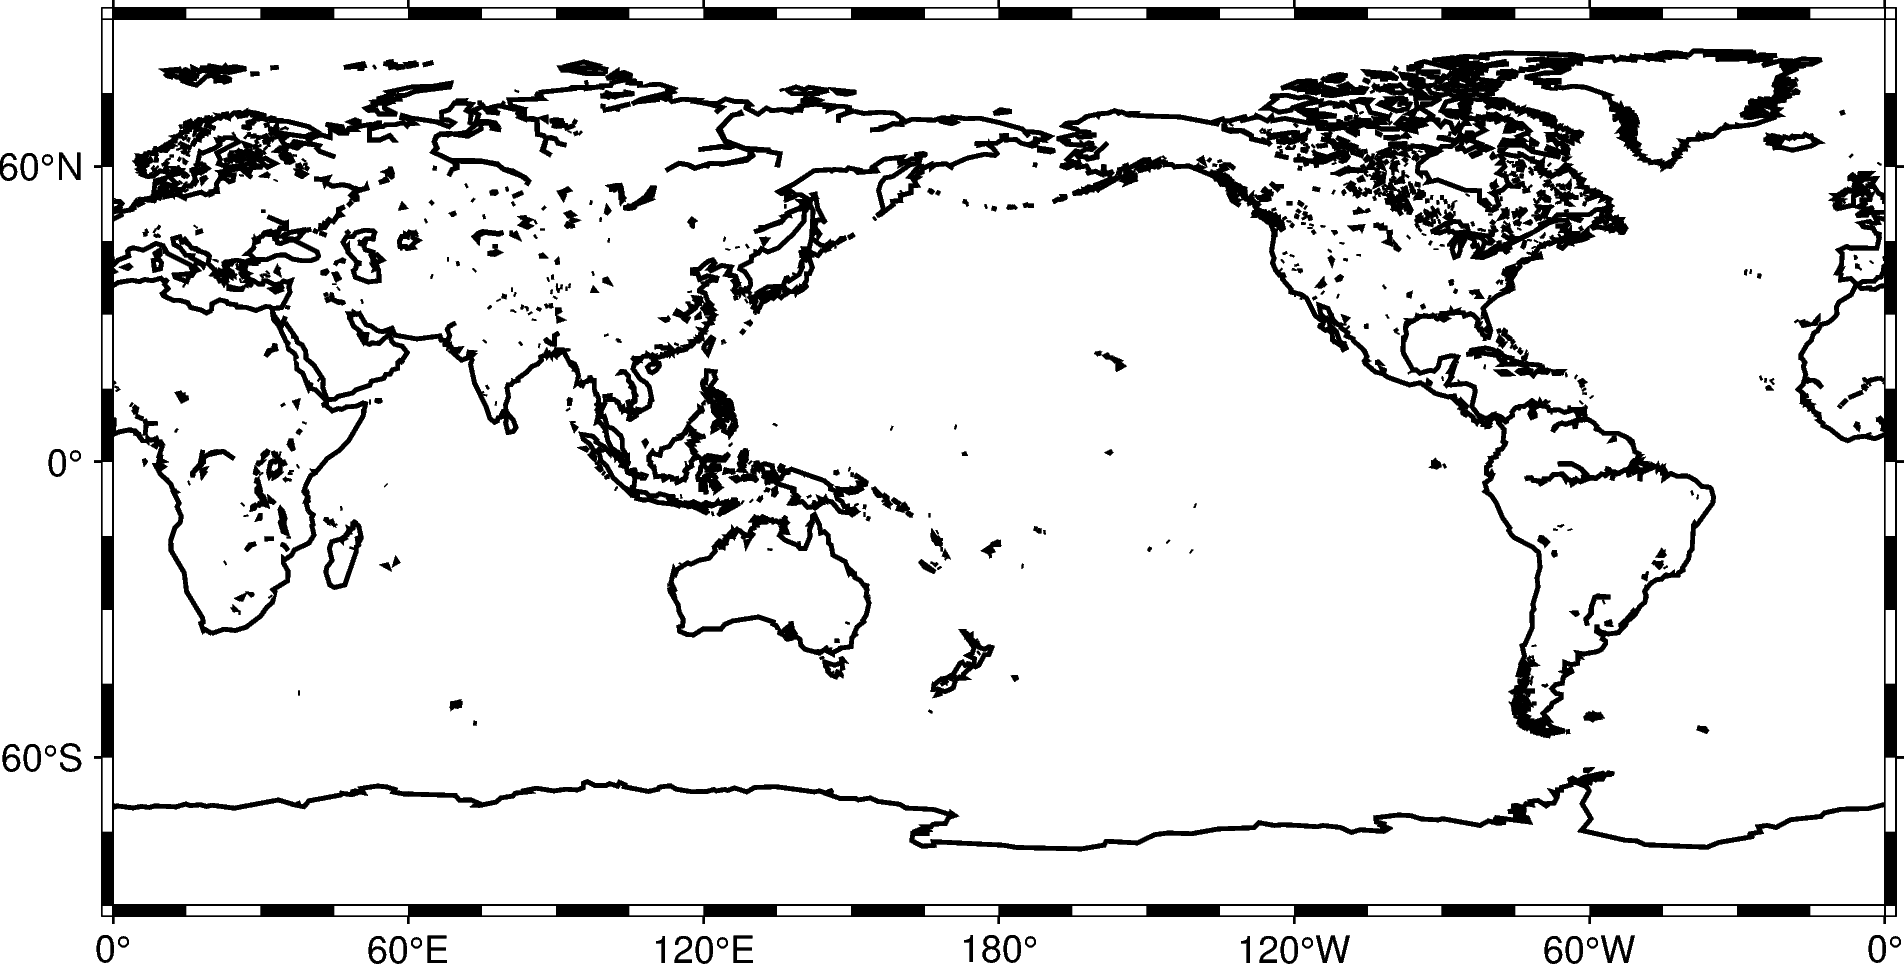

In [ ]:
def file_netcdf(name,grid,descripcion,dt,ttotal): # name 'sample.nc', grid:'/content/examples/e2Asean.grd', descripcion: "Simulacion MQ1"
  import numpy as np
  import netCDF4 as nc4
  import xarray as xr
  from scipy.interpolate import griddata
  from scipy.interpolate import RegularGridInterpolator
  lon_x, lat_y, grd, (ny,nx) =load_surfer(grid)
  lon_x=lon_x.reshape(ny,nx)
  lat_y=lat_y.reshape(ny,nx)
  grid=grd.reshape(ny,nx)
  t = np.arange(0,ttotal+dt,dt)
  pasos = int(ttotal/dt)+1

  f = nc4.Dataset(name,'w', format='NETCDF4') #'w' stands for write
  f.createDimension('lon',nx)
  f.createDimension('lat',ny)
  f.createDimension('time',pasos)

  longitude = f.createVariable('Longitude', 'f4', 'lon')
  latitude = f.createVariable('Latitude', 'f4', 'lat')  
  time = f.createVariable('Time', 'i4', 'time')
  ssh = f.createVariable('SSH', 'f4', ('time', 'lat' , 'lon'))

  longitude[:] = lon_x[0,:]
  latitude[:]  = lat_y[:,0]
  time[:] = t
  lon_lat = [latitude[:],longitude[:]]

  #Add global attributes
  f.description = descripcion
  #Add local attributes to variable instances
  longitude.units = 'degrees'
  latitude.units = 'degrees'
  time.units = 'minutes'
  ssh.units = 'meters'

  for i in range(0,pasos):
    fileName= 'eWave.2D.{0:05d}.ssh'.format(i*60*dt)
    lon, lat, h0 = ew2py(fileName)
    interp = RegularGridInterpolator((lat, lon), h0,bounds_error=False, fill_value=None)
    data = interp((lat_y,lon_x))#interp((lon_x, lat_y))
    ssh[i,:,:] = data
  
  f.close
  grid_xr = xr.open_dataset(name,engine='netcdf4', decode_cf=False).isel(time = 0)
  grid_xr = grid_xr.drop_vars('Time')
  #grid_xr = grid_xr.set_coords(['Longitude', 'Latitude','Time'])
  grid_xr = grid_xr.set_coords(['Longitude', 'Latitude'])
  return f,grid_xr

In [ ]:
grid_nc,grid_xr = file_netcdf('sim1.nc','/content/examples/e2Asean.grd','Simulacion MQ',5,120)

In [ ]:
%cd simulacion/

import pygmt
from functions_easywave import ew2py
from functions_easywave import load_surfer
import numpy as np
import matplotlib.pyplot as plt
#pygmt.show_versions()

#fig = pygmt.Figure()
#fig.coast(region=[0, 360, -80, 80], projection="M0/0/10c", frame="a30fg", shorelines=0.5)
#fig.show()

fig = pygmt.Figure()
fig.grdimage(grid=grid_xr.SSH, projection="M0/0/10c", frame=True)
#fig.show()